# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Our goal is to understand the factors that make a car more or less expensive. As used car dealers, understanding the correct pricing for a vehicle is multifold:
- It helps us understand fair prices to pay when acquiring inventory, so that we are not overpaying
- It helps us price competitively with our competitors, so that consumers will find our lot desirable
- It helps us understand what kind of profit we will expect if we sell the vehicles at a given markup

Therefore, it is critical that we can price our vehicles correctly.
This analysis will enable us to understand which factors influence the price of cars, and even allow us to predict the price of a given vehicle based on its attributes.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('data/vehicles.csv')

In this phase, we want to undertake activities to 1) discover insights, 2) identify interesting subsets of the data, or 3) identify data quality problems.

We shall first look at the data head to get a good understanding.

In [3]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


#### Insights

I am fortunate to have prior experience in this industry, which I will leverage here.

I'll start by identifying attributes that are definitely not germane to this analysis:
- id
- VIN
- Region
- State

ID seems to be a unique identifier for the table; this is useful from a data perspective, but provides no business value.

Actually, vehicle trim can be deduced from the VIN using decoding, but it looks like some of those trim attributes have been added here as their own attributes, and the VIN as a simple string is not useful for us.

I <em>do</em> think that region and state are likely to influence price, actually. However, this is not actionable information for the dealer group were are working for. We need generalizable vehicle price information that can be applied regardless of region and state. So we'll drop these.

The remaining attributes are quite useful and I am excited to analyze them.

#### Useful attributes

Laying out a few specific attributes I believe will likely have the largest relationship to price:
- Year: Vehicles depreciate as soon as they leave the lot. The older the vehicle, the more presumed wear-and-tear
- Odometer: Similar to Year--we expect more wear and tear from vehicles with more mileage
- Condition: The better the condition, the higher the price I expect to see

The remaining attributes I believe will show some relationship to price, but I have no expectations entering this analysis as to how strongly they are correlated.

#### Description of numeric data

There are four numeric column available in the dataset:
 - id
 - price
 - year
 - odometer
 
Again, id is actually a unique identifer, so it's numeric properties are not interesting (an average, min, max, etc. don't make any sense).

Price is what we want to predict. It ranges from 0 to 3,736,928,711. Some obvious data quality issues here! This is not a reasonable price for a car.

Odometer ranges from 0 to 10,000,000. Again, this is indicative of a data quality issue.

Year ranges from 1900 to 2022. 1900 is an unreasonable year for our dataset--I would bet dollars to donuts that there are no used cars on sale from 1900. Anything that old would be a collectible and sold at auction--certainly not relevant to our analysis.

I will use the following analysis to select parameters for these three variables to narrow down our dataset to only useful data.


In [6]:
data.describe(percentiles=[.1,.9])

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
10%,7.304399e+09,5.000000e+02,2003.000000,1.493900e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
90%,7.316419e+09,3.759000e+04,2019.000000,1.773771e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


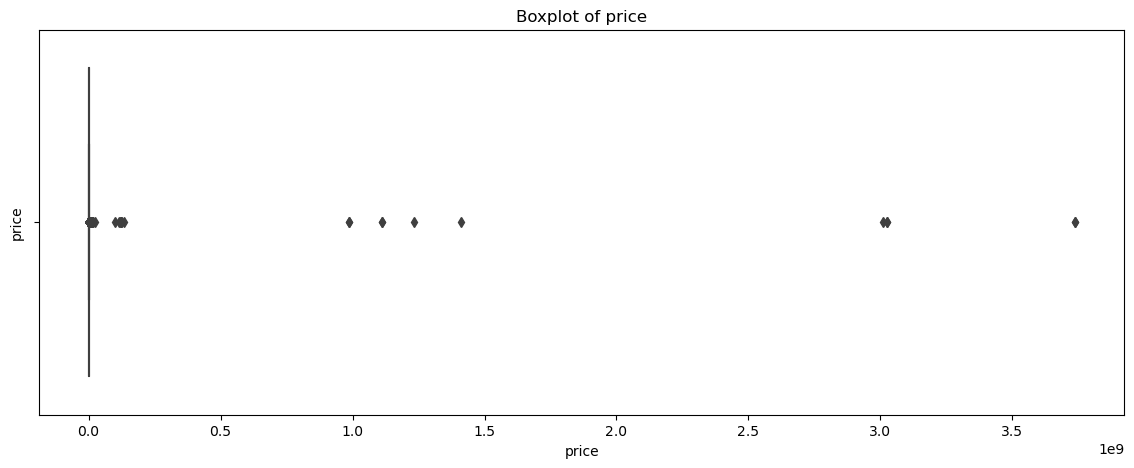

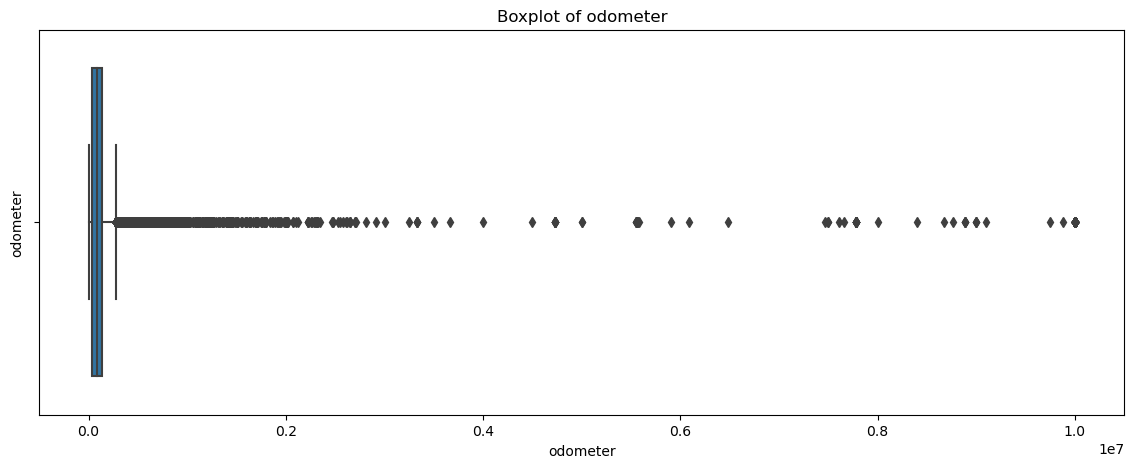

In [7]:
plt.figure(figsize=(14,5))
sns.boxplot(x=data['price'])
plt.title("Boxplot of price")
plt.ylabel("price")
plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(x=data['odometer'])
plt.title("Boxplot of odometer")
plt.ylabel("odometer")
plt.show()

I've rerun the description of the data, this time including different percentile ranks. I've also plotted odometer and price as boxplots to see the distribution, as well as the outliers. I thought a histogram wasn't appropriate for these as they would have too many distinct values to fit neatly into bins, even if the analysis had many bins.

These plots show that the outliers for these two columns is extreme, and mostly on the positive side. From an intuitive sense, values approaching 0 for both price and odometer mileage seem fine; we really need to address the higher outliers by only examining the data through some upper percentile. 90th percentile seems like we may be cutting out some valid values, so let's look ath the 95th percentile value.

In [8]:
data.describe(percentiles=[.05,.95])

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
5%,7.303150e+09,0.000000e+00,1998.000000,6.318000e+03
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
95%,7.316743e+09,4.450000e+04,2020.000000,2.040000e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


44,500 is a bit high for a <em>used</em> car, but not completely unrealistic if the the car was initially expensive and it remains in good condition. A min value of 0 might seem unintuitive, but some vehicles do in fact have 0 book value, and are not worth buying, selling, repairing, or repossession, from a business perspective.

The odometer value is 204,000 at the 95th percentile, which is probably not high enough for some used cars. Let's see it again at the 98th percentile.

In [9]:
data.describe(percentiles=[.02,.98])

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
2%,7.302193e+09,0.000000e+00,1980.000000,2.065800e+02
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
98%,7.316894e+09,5.690000e+04,2020.000000,2.432624e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


243,262 miles seems more reasonable. Let's use this for the cutoff when we prep our data.

Now to address the "year" column.

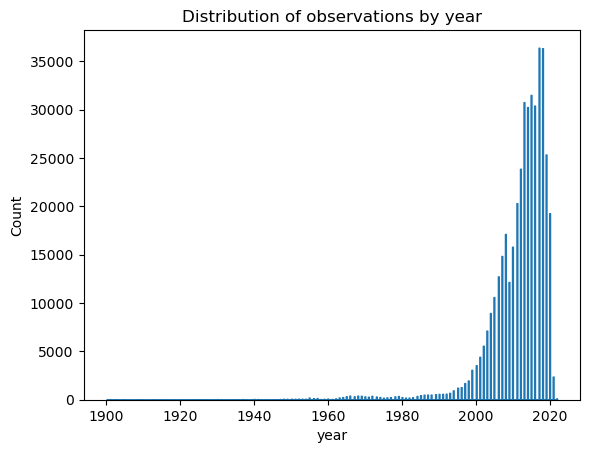

In [10]:
sns.histplot(data['year'], element='step')
plt.title('Distribution of observations by year')
plt.show()

We can see a major skew of the data toward the far right of the timeline. In conjunction with our above describe, we know that > 90% of the observations are for vehicles of year on or after 2003. Reviewing the above graph, I think we can expand that slightly and take observations from 2000 forward.

#### Description of non-numeric data

We should evaluate the non-numeric data as well, to see if there's any junk data, or if there's any cleaning or standardization needed.

In [11]:
data.describe(exclude=[np.number])

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
count,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426880
unique,404,42,29649,6,8,5,6,3,118246,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,3608,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,50614


The only thing that stands out here is the fact that the unique count of values for "model" is extraordinarily high. We should determine whether this data is even useful in its current state.

One way to do this is by looking at unique values with the lowest counts, as this will give us some understanding of the nature of the data.

In [12]:
# need to drop missing values for this analysis to make it work
model_counts = data['model'].dropna().value_counts()
sorted_model_counts = model_counts.sort_values()
print(sorted_model_counts.head(20))

Land Crusier FJ55              1
qx60 pure awd                  1
c7500 service truck w crane    1
Workhorse P42 Step Van         1
express shuttle bus            1
fuso fe180 18' box t           1
equinox fwd 4dr ls             1
c7500 enclosed service truc    1
STERLING Acterra Lube Truck    1
e450 azure hybrid shuttle      1
f750 boom bucket truck         1
tl 3.2 sedan                   1
c4500 4x4 service tru          1
focus electric automatic       1
legacy gt special edition      1
f-350 super duty xl 4dr sup    1
express box van truck          1
evoque hs                      1
express 2500 carpet c          1
shuttle bus                    1
Name: model, dtype: int64


This data is really, really messy. It looks like it is possibly free entry, because there is no standardization here.

Even though model would be incredibly useful for this analysis, I think we--unfortunately--simply can't use this column.

I don't think any further inspection is needed for this data in terms of insights, so we can begin looking for other aspects related to data quality.

#### Data quality

Recall that a general approach for data understanding and preparation is the following:
1. Finding missing values, if they are appropriate, and how to handle them
2. Addressing the missing values, if applicable
3. Identifying duplicates, and determining if they are true duplicates or just records with similarity of available attributes
4. Examine outliers

Let's look at the .head() again for info.

In [13]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


Wow! Just by looking at this head information I can already see there are a lot of NaNs in the dataset.

Let's see just how many.

In [14]:
nulls = pd.DataFrame(data.isnull().sum())
nulls = nulls.rename(columns={0: 'Missing count'})
nulls

,Missing count
id,0
region,0
price,0
year,1205
manufacturer,17646
model,5277
condition,174104
cylinders,177678
fuel,3013
odometer,4400


We can see that there are many missing values! Dropping records with missing values is often a good approach to handle them, but how much data will we have left over if we do that?

In [15]:
data_with_nulls = data[data.isnull().any(axis=1)]
print(f'Number of rows with missing data: {data_with_nulls.shape[0]}')
print(f'Number of rows without missing data: {data.shape[0] - data_with_nulls.shape[0]}')

Number of rows with missing data: 392012
Number of rows without missing data: 34868


About 35,000 records remain. That's plenty to train and test a model.

That being said, we will need to validate again once we also execute our other data prep changes.

<b>Duplicates</b>

It's important to remove duplicated data. Let's see if we can find any. The presence of a unique identifying key gives me hope that there will be none.


In [16]:
duplicates = data[data.duplicated()]

print(f'Duplicates: {duplicates.shape[0]}')

Duplicates: 0


This seems good, but what if there are duplicates prior to the assigning of ID?

Let's double-check.

In [17]:
data_clean = data.drop('id', axis=1)

duplicates = data_clean[data_clean.duplicated()]

print(f'Duplicates: {duplicates.shape[0]}')

Duplicates: 56202


This suggests there are duplicates in the dataset. Consider this VIN: JN8AZ08W03W203477.

There are several records of this vehicle in the same region, with the same odometer mileage, same price, and frankly the same attributes across the board. This seems like the kind of duplication that will need to be addressed in the data prep phase.

<b>Outliers</b>

We coincidentally stumbled upon this while describing the numeric data, and have made the following plan for changes:
1. Limit records to those with odometer values less than the 98th percentile and greater than the 2nd percentile
2. Limit records to those with price values less than the 95th percentile and greater than the 5th percentile
3. Limit records to those with a year of 2000 or later

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [18]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [19]:
# drop model column, because it has junk values
# drop id because it doesnt have business meaning

data.drop(['model', 'id'], axis=1, inplace=True)



In [20]:
# drop missing values
data.dropna(inplace=True)

In [21]:
# dedupe
data.drop_duplicates(inplace=True)


In [22]:
# now that we've deduped, we can drop VIN, because it has no business value in this context
data.drop('VIN', axis=1, inplace=True)


We will drop manufacturer as well. Though branding is important, there are two valid reasons for doing so:
1. It is a bit contrary to our generalizable nature of our analysis. Much like with state, many dealers are locked into manufacturer from time of inception or due to contractual obligations
2. There are simply too many manufacturers, which complicates the regression. I think a future analysis would be to perform individual regressions <em>by</em> manufacturer, and supply this to relevant dealers

In [23]:
data.drop(['manufacturer'], axis=1, inplace=True)

In [24]:
# drop state and region because we are looking for a generalized analysis of vehicle price
data.drop(['region', 'state'], axis=1, inplace=True)

In [25]:
data.head()

,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color
126,0,2018.0,like new,6 cylinders,gas,68472.0,clean,automatic,rwd,full-size,van,white
127,0,2019.0,like new,6 cylinders,gas,69125.0,clean,automatic,rwd,full-size,van,white
128,0,2018.0,like new,6 cylinders,gas,66555.0,clean,automatic,rwd,full-size,van,white
215,4000,2002.0,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue
219,2500,1995.0,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white


Time to step back and review. Looks good so far! We still need to handle outliers, so lets take care of that now

#### Outlier

I've chosen to rely on my subject matter expertise and exploratory data analysis to identify thresholds for removing outliers. This is essentially an IQR approach, although instead of using Quartiles I am using different percentiles as cutoff.

Note that the previously determined percentiles may have changed, as we have modified the dataset by dropping missing values and so on. Let's just validate they are still reasonable.

In [26]:
percentile_2_odom = data['odometer'].quantile(.02)
percentile_98_odom = data['odometer'].quantile(.98)

percentile_5_price = data['price'].quantile(.05)
percentile_95_price = data['price'].quantile(.95)

print('Odometer 2%: ',+ percentile_2_odom)
print('Odometer 98%: ', + percentile_98_odom)
print('Price 5%: ', + percentile_5_price)
print('Price 95%: ', + percentile_95_price)

Odometer 2%:  6521.4
Odometer 98%:  235000.0
Price 5%:  0.0
Price 95%:  41500.0


Still looks valid based on my opinion. Let's trim down the dataset one more time to remove this bad data and visually verify.

In [27]:
data = data.query('odometer >= @percentile_2_odom and odometer <= @percentile_98_odom \
                        and price >= @percentile_5_price and price <= @percentile_95_price \
                        and year >= 2002')

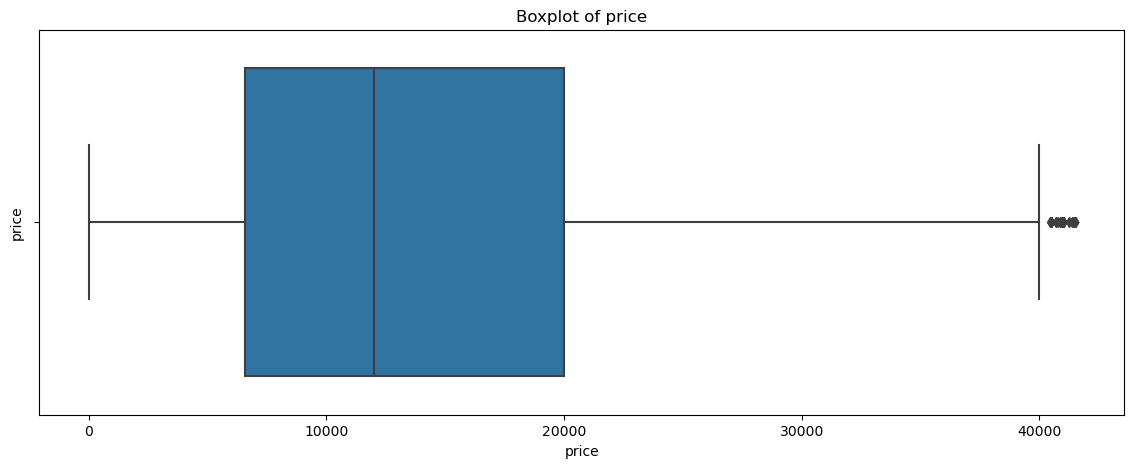

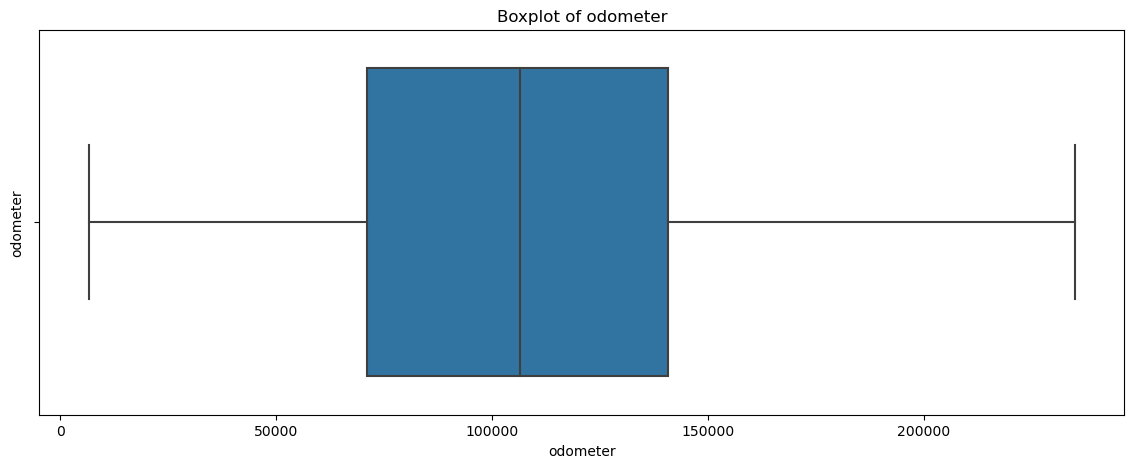

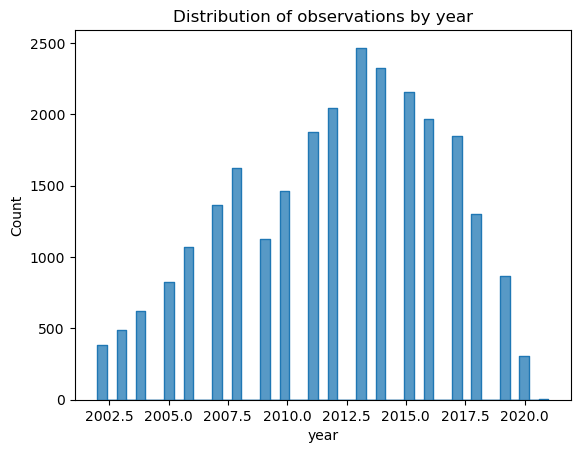

In [28]:
plt.figure(figsize=(14,5))
sns.boxplot(x=data['price'])
plt.title("Boxplot of price")
plt.ylabel("price")

plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(x=data['odometer'])
plt.title("Boxplot of odometer")
plt.ylabel("odometer")

plt.show()

sns.histplot(data['year'], element='step')
plt.title('Distribution of observations by year')
plt.show()

In [29]:
data.head()

,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color
126,0,2018.0,like new,6 cylinders,gas,68472.0,clean,automatic,rwd,full-size,van,white
127,0,2019.0,like new,6 cylinders,gas,69125.0,clean,automatic,rwd,full-size,van,white
128,0,2018.0,like new,6 cylinders,gas,66555.0,clean,automatic,rwd,full-size,van,white
215,4000,2002.0,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue
268,9000,2008.0,excellent,4 cylinders,gas,56700.0,clean,automatic,rwd,compact,convertible,white


In [30]:
data.describe()

,price,year,odometer
count,26149.000000,26149.000000,26149.000000
mean,14106.525374,2012.005966,106920.114345
std,10132.998794,4.342087,49961.782322
min,0.000000,2002.000000,6533.000000
25%,6600.000000,2009.000000,71000.000000
50%,11990.000000,2013.000000,106456.000000
75%,19995.000000,2015.000000,140650.000000
max,41500.000000,2021.000000,235000.000000


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26149 entries, 126 to 426836
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         26149 non-null  int64  
 1   year          26149 non-null  float64
 2   condition     26149 non-null  object 
 3   cylinders     26149 non-null  object 
 4   fuel          26149 non-null  object 
 5   odometer      26149 non-null  float64
 6   title_status  26149 non-null  object 
 7   transmission  26149 non-null  object 
 8   drive         26149 non-null  object 
 9   size          26149 non-null  object 
 10  type          26149 non-null  object 
 11  paint_color   26149 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 2.6+ MB


In [32]:
data.describe(exclude=[np.number])

,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color
count,26149,26149,26149,26149,26149,26149,26149,26149,26149
unique,6,8,5,6,3,3,4,13,12
top,excellent,4 cylinders,gas,clean,automatic,4wd,full-size,SUV,white
freq,15225,9154,24198,25224,24696,11978,14756,7373,7275


#### Feature engineering

Now that we have cleaned the data, we should consider ways to modify the data simply for the benefit of modeling.

I'd prefer it if some of our categorical data were numerical, so that we can use them in our modeling, especially linear regression.

Some further exploratory data analysis may help us understand if we can trim our list of potential variables down further, making the model simpler.

We shall iterate over our nominal data to see if there are any categories that don't seem to have influence on the price.


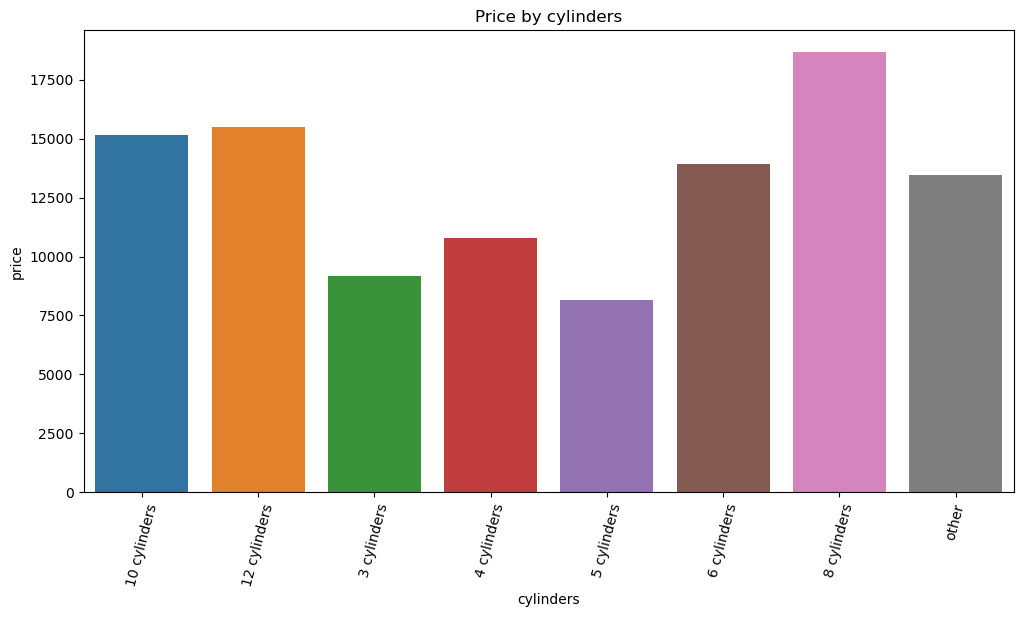

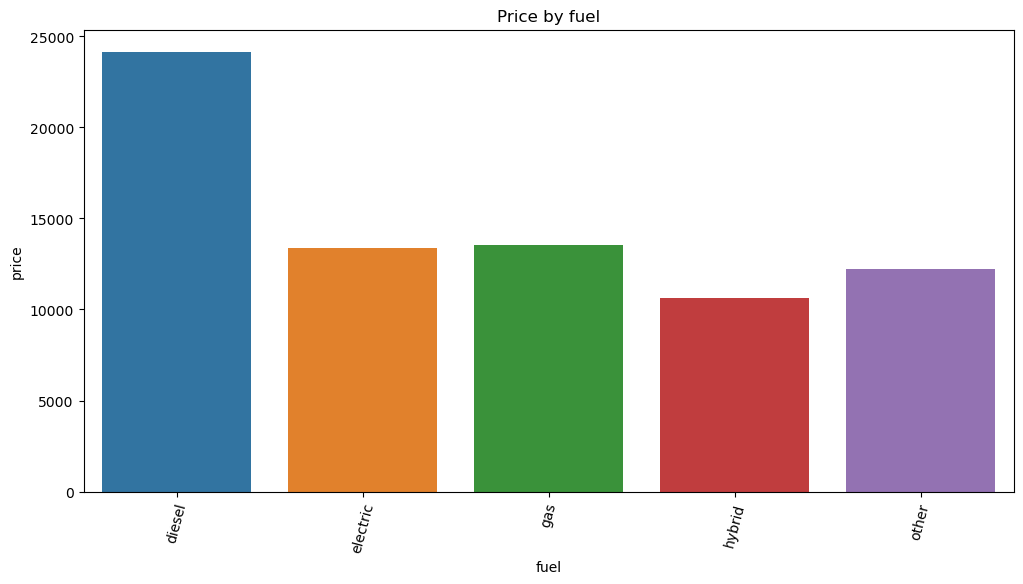

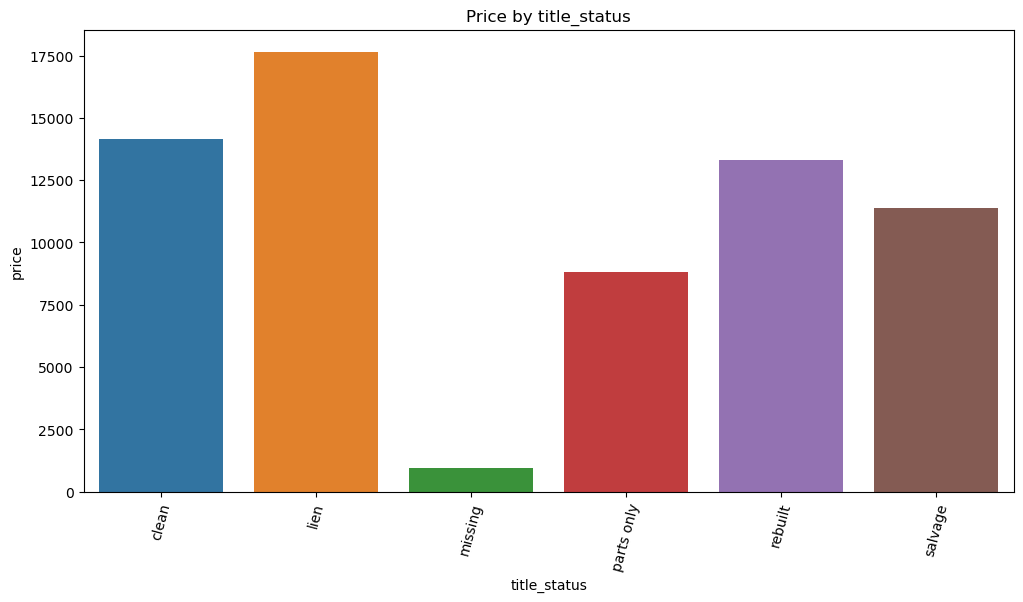

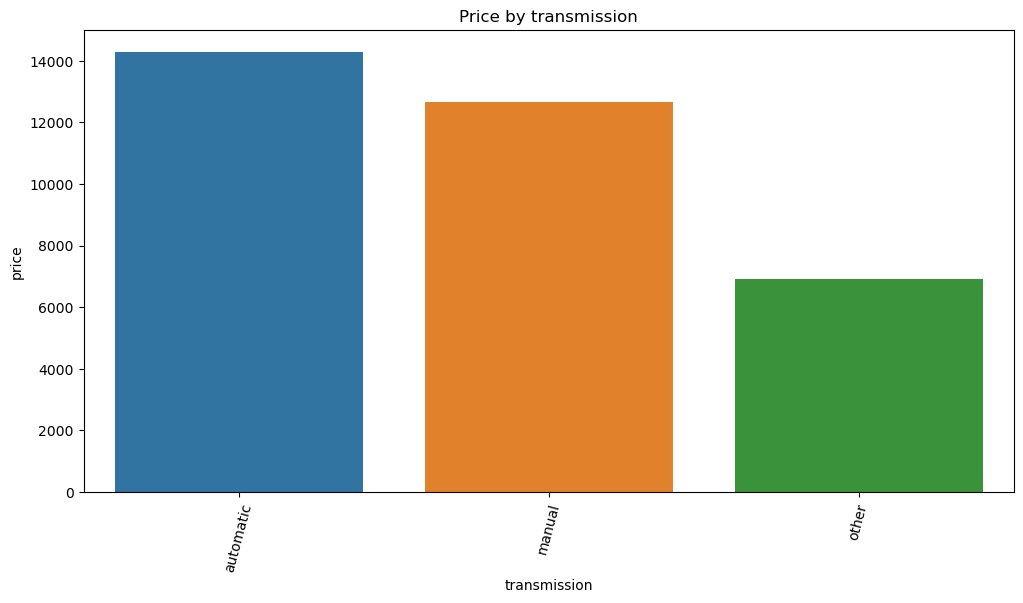

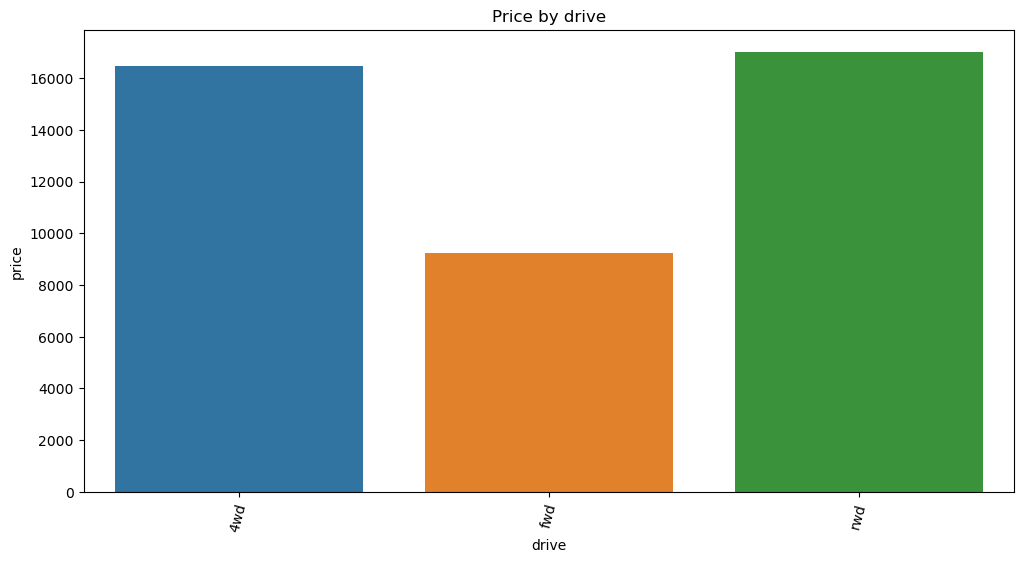

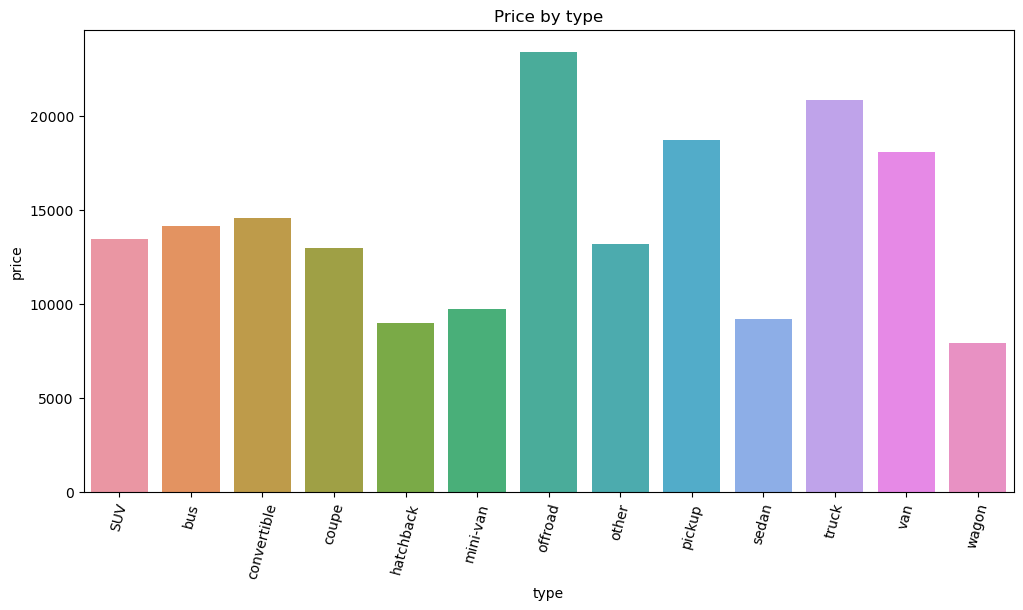

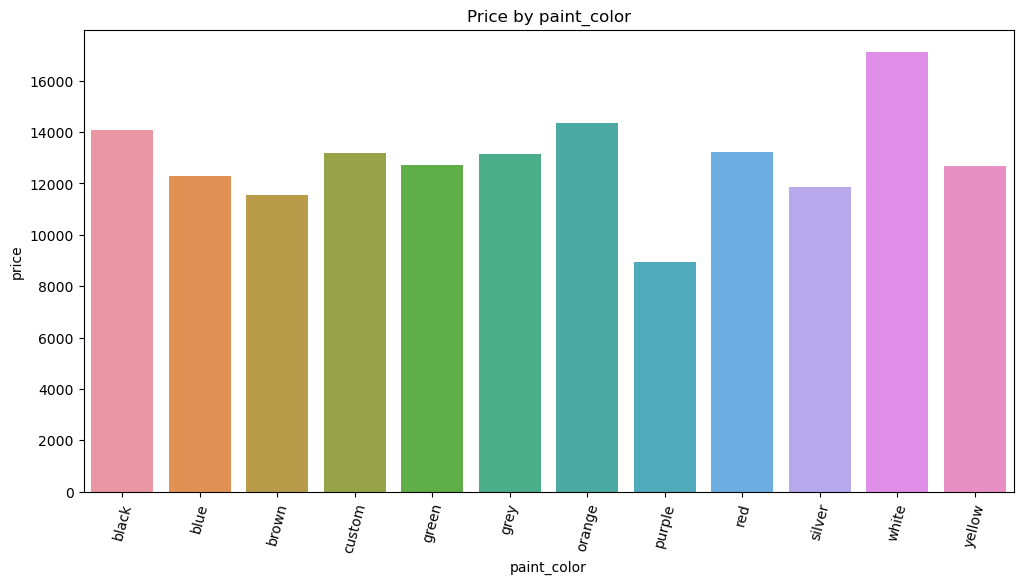

In [33]:
nominal_columns = ['cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type','paint_color']


for column in nominal_columns:
    plt.figure(figsize= [12, 6])
    data_sorted = data.sort_values(by=column)

    sns.barplot(data=data_sorted, x=column, y='price', errorbar=None)
    plt.xticks(rotation=75)
    plt.title(f'Price by {column}')
    plt.ylabel('price')
    plt.xlabel(f'{column}')

    plt.show()

All of the nominal columns has some relation with price, so we should one-hot encode them in order to make them usable in linear regression.

In [34]:
data = pd.get_dummies(data, columns = nominal_columns, drop_first = True)

In [35]:
data

,price,year,condition,odometer,size,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
126,0,2018.0,like new,68472.0,full-size,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
127,0,2019.0,like new,69125.0,full-size,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
128,0,2018.0,like new,66555.0,full-size,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
215,4000,2002.0,excellent,155000.0,compact,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
268,9000,2008.0,excellent,56700.0,compact,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426779,5995,2004.0,good,233011.0,full-size,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
426780,34995,2014.0,good,58095.0,full-size,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
426782,23995,2013.0,good,114215.0,full-size,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
426784,24995,2014.0,good,128722.0,full-size,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


We also have two ordinal columns, size and condition. Let's map these to numerics.

In [36]:
data['condition'].unique()

array(['like new', 'excellent', 'good', 'fair', 'salvage', 'new'],
      dtype=object)

In [37]:
conditions = data[['condition']].values.reshape(-1,1)

# use scikit learn encoder
condition_encoder = OrdinalEncoder(categories=[['salvage', 'fair', 'good', 'excellent', 'like new', 'new']])
conditions_encoded = condition_encoder.fit_transform(conditions)

data['condition_encoded'] = conditions_encoded

# just to validate the encoding was successful
pd.crosstab(data['condition_encoded'], data['condition'])

condition,excellent,fair,good,like new,new,salvage
condition_encoded,,,,,,
0.0,0,0,0,0,0,26
1.0,0,259,0,0,0,0
2.0,0,0,7793,0,0,0
3.0,15225,0,0,0,0,0
4.0,0,0,0,2769,0,0
5.0,0,0,0,0,77,0


In [38]:
# repeat encoding for size
data['size'].unique()


array(['full-size', 'compact', 'mid-size', 'sub-compact'], dtype=object)

In [39]:
sizes = data[['size']].values.reshape(-1,1)

# use scikit learn encoder
size_encoder = OrdinalEncoder(categories=[['sub-compact', 'compact', 'mid-size', 'full-size']])
sizes_encoded = size_encoder.fit_transform(sizes)

data['size_encoded'] = sizes_encoded

# just to validate the encoding was successful

pd.crosstab(data['size_encoded'], data['size'])

size,compact,full-size,mid-size,sub-compact
size_encoded,,,,
0.0,0,0,0,519
1.0,3161,0,0,0
2.0,0,0,7713,0
3.0,0,14756,0,0


In [40]:
# drop the ordinal columns, leave encoded versions
data.drop('size', axis=1, inplace=True)
data.drop('condition', axis=1, inplace=True)
data

,price,year,odometer,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,...,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,condition_encoded,size_encoded
126,0,2018.0,68472.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,4.0,3.0
127,0,2019.0,69125.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,4.0,3.0
128,0,2018.0,66555.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,4.0,3.0
215,4000,2002.0,155000.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,1.0
268,9000,2008.0,56700.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426779,5995,2004.0,233011.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,2.0,3.0
426780,34995,2014.0,58095.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2.0,3.0
426782,23995,2013.0,114215.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2.0,3.0
426784,24995,2014.0,128722.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,2.0,3.0


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

We have a lot of features. But we also have lots of data! So we are not impeded by the curse of dimensionality, and can simply proceed with our modeling efforts. A rule of thumb is to have 5 training values per dimension, so we need 240 training examples--we have two orders of magnitude more than that.

In [70]:
# split the data
random_seed = 42
X = data.drop(['price'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)

In [71]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_test)

In [72]:
ridge_model = Ridge(alpha=1.0) 
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

In [73]:
lasso_model = Lasso(alpha=1.0) 
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

We can compare the MSE from each regression and find the most accurate one.

In [74]:
linear_mse = mean_squared_error(linear_predictions, y_test)
print(f'MSE for Linear: {linear_mse}')

MSE for Linear: 58544570.585298516


In [75]:
ridge_mse = mean_squared_error(ridge_predictions, y_test)
print(f'MSE for Ridge: {ridge_mse}')

MSE for Ridge: 58535671.32086692


In [76]:
lasso_mse = mean_squared_error(lasso_predictions, y_test)
print(f'MSE for Lasso: {lasso_mse}')

MSE for Lasso: 58514216.69642774


All models are close in accuracy! It seems like Ridge model marginally edges out the other two.

Let's take a look.


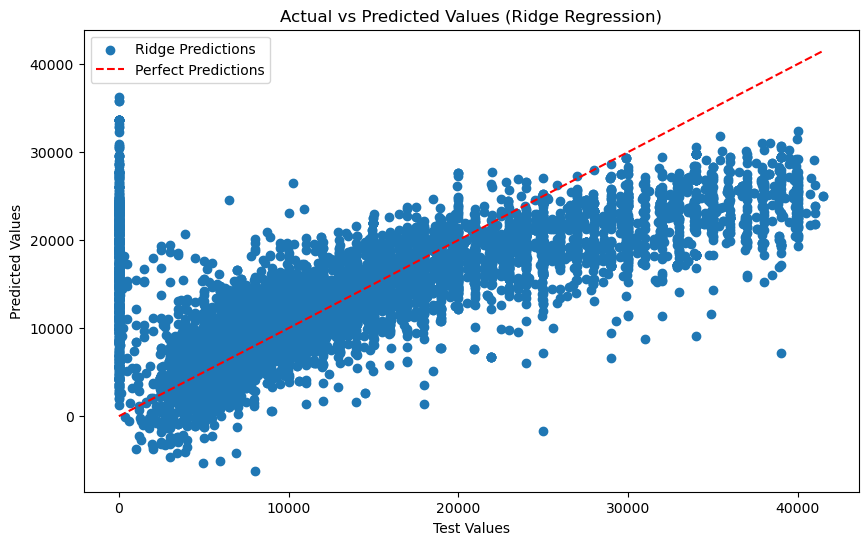

In [77]:

# plotting predictions vs test
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ridge_predictions, alpha=1, label='Ridge Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Predictions')
plt.title('Actual vs Predicted Values (Ridge Regression)')
plt.xlabel('Test Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

Overall, this is not bad, but you can see that the Ridge model tends to under-predict the price of the most expensive vehicles from the test dataset.

Is there a way to optimize this further by tweaking the alpha value? Well we can use GridSearchCV to optimize the alpha hyper parameter.

In [78]:
# generate some alphas, put them in a grid, then run search
alphas = np.linspace(0.1, 10, 20)
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge_model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f'Best alpha: {best_alpha}')



Best alpha: 3.2263157894736847


In [79]:
# Run model again with the better alpha, and check the MSE
ridge_model = Ridge(alpha=best_alpha) 
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

new_ridge_mse = mean_squared_error(ridge_predictions, y_test)
print(f'MSE for new Ridge: {new_ridge_mse}')
print(f'New MSE is lower than old MSE? {new_ridge_mse < ridge_mse}')
print(f'Difference in MSE = {new_ridge_mse - ridge_mse}')

MSE for new Ridge: 58526023.17485418
New MSE is lower than old MSE? True
Difference in MSE = -9648.146012738347


Now that we've optimized the hyperparameter, lets do one more cross validation to get comfortable with our proposed model, using the KFold technique.

In [80]:
kf = KFold(n_splits=5, shuffle=True)

scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=kf)
scores_positive = -scores
print(f'Cross Validation Scores: {scores_positive}')

Cross Validation Scores: [58045068.82357895 58484155.27858708 58443722.3285849  59767888.38870091
 58225750.11082201]


These are all close to our initial score. We can feel comfortable proceeding with this model.

Lastly we should examine our coefficents for further insight.

In [88]:
ridge_coef = ridge_model.coef_
feature_names = X.columns
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_coef})
coefficients_df.sort_values(by='Coefficient')

,Feature,Coefficient
19,transmission_other,-9687.055421
10,fuel_gas,-6294.723753
12,fuel_other,-5901.779247
9,fuel_electric,-4410.341460
11,fuel_hybrid,-4368.976263
33,type_wagon,-3324.869232
3,cylinders_3 cylinders,-2938.160084
20,drive_fwd,-2884.960682
17,title_status_salvage,-2379.904122
30,type_sedan,-1723.270400


In [89]:
coefficients_df

,Feature,Coefficient
0,year,628.691601
1,odometer,-0.047955
2,cylinders_12 cylinders,1969.689059
3,cylinders_3 cylinders,-2938.160084
4,cylinders_4 cylinders,-501.706638
5,cylinders_5 cylinders,-214.807063
6,cylinders_6 cylinders,862.523044
7,cylinders_8 cylinders,2554.137780
8,cylinders_other,2258.524660
9,fuel_electric,-4410.341460


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Note: This information is also available in the README file associated with this repo.

#### Problem Statement

The correct pricing model for vehicles is absolutely essential for used auto dealers, both in terms of the inventory they want to sell, as well as the inventory they want to acquire from consumer trade-ins, as well as auction purchases. 

The margins in this industry are incredibly thin, so overpaying to bring in inventory can cripple these cash-starved business.

Likewise, correct pricing of vehicles for sale is essential, because underpricing will further cut into the already thin margins, and overpricing will lead to a loss of business, especially due to the growth digital vehicle marketplaces and the digital availabilty of dealerships that both allow consumers to find the cheapest vehicles available.

Our goal is to design a model that can reliably predict the price of a vehicle so that we can use it to make our own pricing decisions.

#### Approach

We applied an industry standard approach to this problem, called CRISP-DM. Without being too technical, the general steps are:
 - Understand the problem
 - Understand the data
 - Prepare the data
 - Model the data
 - Evaluate findings
 - Deploy (share findings with stakeholders)
 
The data we acquired needed significant preparation to be useful for our purposes.
We had many incomplete vehicle records (missing important values like odometer and title status), there were duplicates in the data, and some of the attributes contained junk values--odometers with 10 million miles, vehicle prices in the hundreds of thousands, etc.

Removing this "bad" data was straightforward, but unfortunately we needed to dispense with some attributes that might have some bearing on the price of the car, like model and manufacturer. Nonetheless, we feel that this is a generalizable model that can be used for a given dealership, regardless of region or brand. 

#### Results
We were able to produce a satisfactory model, with the one qualification that the model has a tendency to understate the true price for used cars over $25,000. For this reason, we recommend that this model be used with caution for higher priced vehicles, and instead more time should be allocated for follow-up.

We evaluated several models, selected the best one, and optimized it.

In terms of individual features, more expensive vehicles tend to have the following traits:
 - Larger
 - Utility nature such as pickup, truck, or offroad
 - Lower mileage (every mile reduces the price by ~ .05 dollars, on average)
 - Better condition
 - More powerful engine (although 8 cylinder engines have a higher price than 12 cylinder engines)
 - Manual transmission (although this could be due to the specialty nature of these vehicles, as automatic is now standard)
 - Title is secure
 
 From a relative perspective, rear-wheel drive and hybrid gas systems produce a higher price compared to their counterparts.

#### Recommendation(s)

We advise dealers to follow current trends and acquire and sell larger vehicles with hauling or offroad capabilites. A medium large engine, good condition, and low mileage will also contribute to a higher price.

We also advise dealers to stay away from salvage and parts vehicles, and only stick to vehicles that have a title status of "lien".


#### Next steps
It would benefit branded dealers to know if these trends hold true by manufacturer. Perhaps more powerful engine has a greater impact for Fords than it does for Hondas. We can create custom models for dealers who exclusively sell certain brands to further tailor their pricing.

Additionally, there is scope to improve the predictive ability for this model for higher priced vehicles. This would take time and would require more model testing and evaluation, but would help for dealers who sell higher-end vehicles.